<a href="https://colab.research.google.com/github/RheedWhan/Lindblad_Equation_SOlver/blob/main/FEM_CNN_Lindblad_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FEM and Analytical Solution

In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd
from scipy.sparse import diags
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ============================================================
# PARAMETERS
# ============================================================
N = 100                 # grid points
x_min, x_max = -10, 10  # domain
x_nodes = np.linspace(x_min, x_max, N)
dx = x_nodes[1] - x_nodes[0]

t_final = 1.0
num_steps = 100
dt = t_final / num_steps

m = 1.0
hbar = 1.0
gamma = 0.05

sigma = 1.0
x_mean = 0.0
k0 = 0.0

# ============================================================
# FEM MATRICES (1D Laplacian with Dirichlet BCs)
# ============================================================
main_diag = -2.0 * np.ones(N)
off_diag = np.ones(N - 1)
laplacian = diags([off_diag, main_diag, off_diag], [-1, 0, 1]) / dx**2

# Lumped mass matrix (here: uniform grid)
M1_lumped = np.ones(N) * dx

# Hamiltonian operator
H = -(hbar**2) / (2 * m) * laplacian

# ============================================================
# INITIAL STATE (Gaussian wavepacket density matrix)
# ============================================================
psi0 = (1.0 / (np.pi * sigma**2))**0.25 * np.exp(-((x_nodes - x_mean)**2) / (2 * sigma**2))
rho0 = np.outer(psi0, np.conjugate(psi0))

# Flatten density matrix for vectorized FEM evolution
rho_vec = rho0.flatten()

# ============================================================
# TIME EVOLUTION (Forward Euler for simplicity)
# ============================================================
records = []
diag_densities = []   # store diagonal densities for plotting

for step in range(num_steps + 1):
    t = step * dt
    rho_t = rho_vec.reshape((N, N))

    # --- Compute observables ---
    diag_vals = np.real(np.diag(rho_t)).copy()   # probability density
    trace = np.sum(diag_vals * M1_lumped)
    if trace != 0:
        diag_vals = diag_vals / trace

    purity = np.sum(np.abs(rho_t.flatten())**2) * dx**2
    mean_x = np.sum(x_nodes * diag_vals * M1_lumped)
    var_x = np.sum(((x_nodes - mean_x)**2) * diag_vals * M1_lumped)

    records.append({"time": t, "purity": purity, "mean_x": mean_x, "var_x": var_x})
    diag_densities.append(diag_vals)

    # --- Lindblad time step ---
    if step < num_steps:
        comm = H @ rho_t - rho_t @ H
        lindblad = -gamma * (np.subtract.outer(x_nodes, x_nodes)**2) * rho_t
        drho = -(1j / hbar) * comm + lindblad
        rho_vec = (rho_t + dt * drho).flatten()

# Save FEM results
df = pd.DataFrame(records)

# ============================================================
# ANALYTICAL CLOSED-FORM SOLUTION
# ============================================================
def analytical_closed_form(t, sigma0, gamma, x_nodes, x0=0.0, k0=0.0, m=1.0, hbar=1.0):
    """Return purity, mean_x, var_x, and diagonal density at time t."""
    sigma_t2 = sigma0**2 + (hbar * t / (m * sigma0))**2
    purity = 1.0 / np.sqrt(1 + 4 * gamma * sigma_t2 * t)
    mean_x = x0
    var_x = sigma_t2 / 2
    # diagonal density
    diag = (1.0 / np.sqrt(np.pi * sigma_t2)) * np.exp(-((x_nodes - x0)**2) / sigma_t2)
    return purity, mean_x, var_x, diag

# Add analytical columns
df["purity_analytical"] = 0.0
df["mean_x_analytical"] = 0.0
df["var_x_analytical"] = 0.0

analytical_densities = []

for i, t in enumerate(df["time"]):
    pa, xa, va, diag_a = analytical_closed_form(t, sigma, gamma, x_nodes, x_mean, k0)
    df.loc[i, "purity_analytical"] = pa
    df.loc[i, "mean_x_analytical"] = xa
    df.loc[i, "var_x_analytical"] = va
    analytical_densities.append(diag_a)

# ============================================================
# ERROR ANALYSIS
# ============================================================
df["purity_error"] = np.abs(df["purity"] - df["purity_analytical"])
df["var_x_error"] = np.abs(df["var_x"] - df["var_x_analytical"])

# Save extended results
out_path = "lindblad_fem_vs_exact.csv"
df.to_csv(out_path, index=False)
print(f"[Saved FEM vs Exact Analytical results to {out_path}]")

[Saved FEM vs Exact Analytical results to lindblad_fem_vs_exact.csv]


In [ ]:
df.loc[df['time'].isin([0.00, 0.25, 0.50, 0.75, 1.00])]

,time,purity,mean_x,var_x,purity_analytical,mean_x_analytical,var_x_analytical,purity_error,var_x_error
0,0.00,1.000000,1.040834e-16,0.500000,1.000000,0.0,0.50000,3.996803e-15,0.000000
25,0.25,0.976030,1.196959e-16,0.529833,0.974451,0.0,0.53125,1.578847e-03,0.001417
50,0.50,0.951090,9.887924e-17,0.623753,0.942809,0.0,0.62500,8.281389e-03,0.001247
75,0.75,0.922960,1.964574e-16,0.784720,0.900070,0.0,0.78125,2.289002e-02,0.003470
100,1.00,0.890208,1.363930e-16,1.015682,0.845154,0.0,1.00000,4.505400e-02,0.015682


## Visualisation


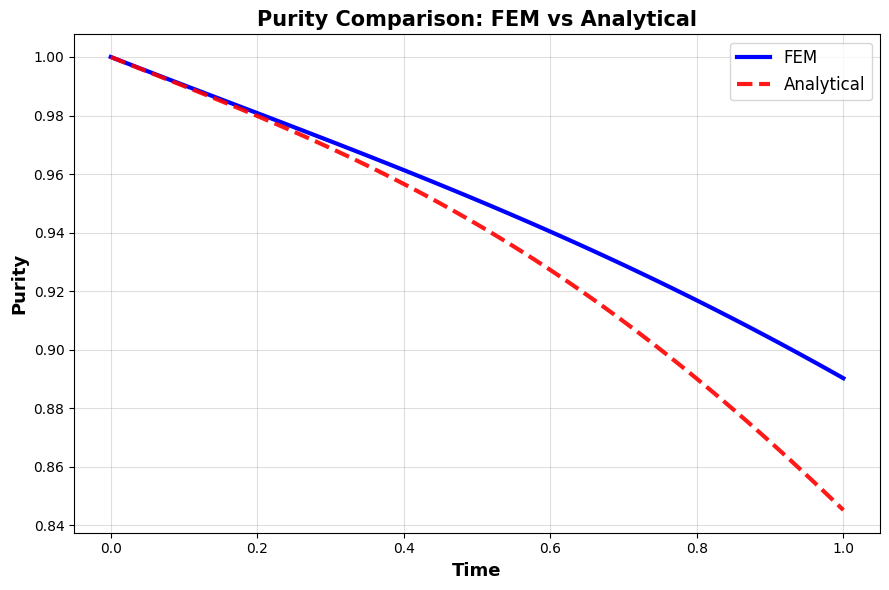

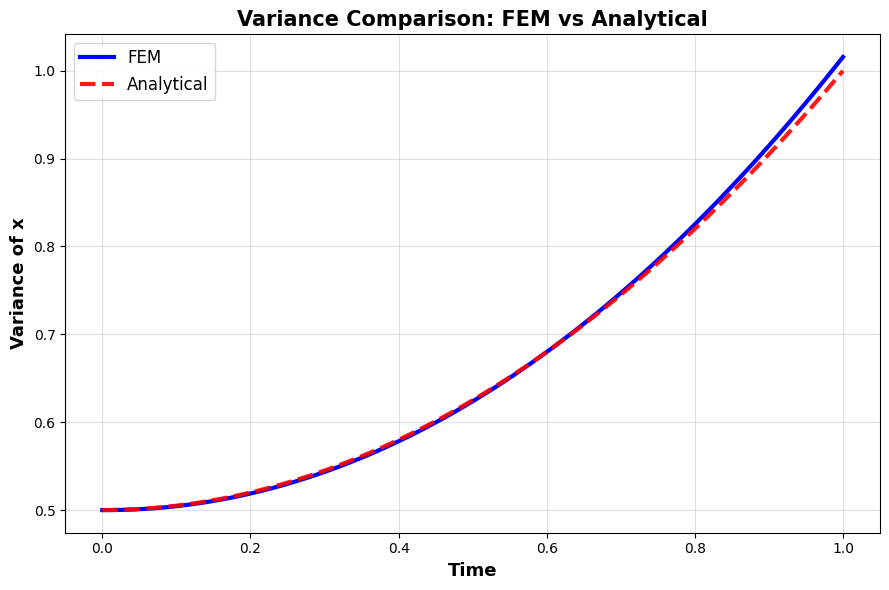

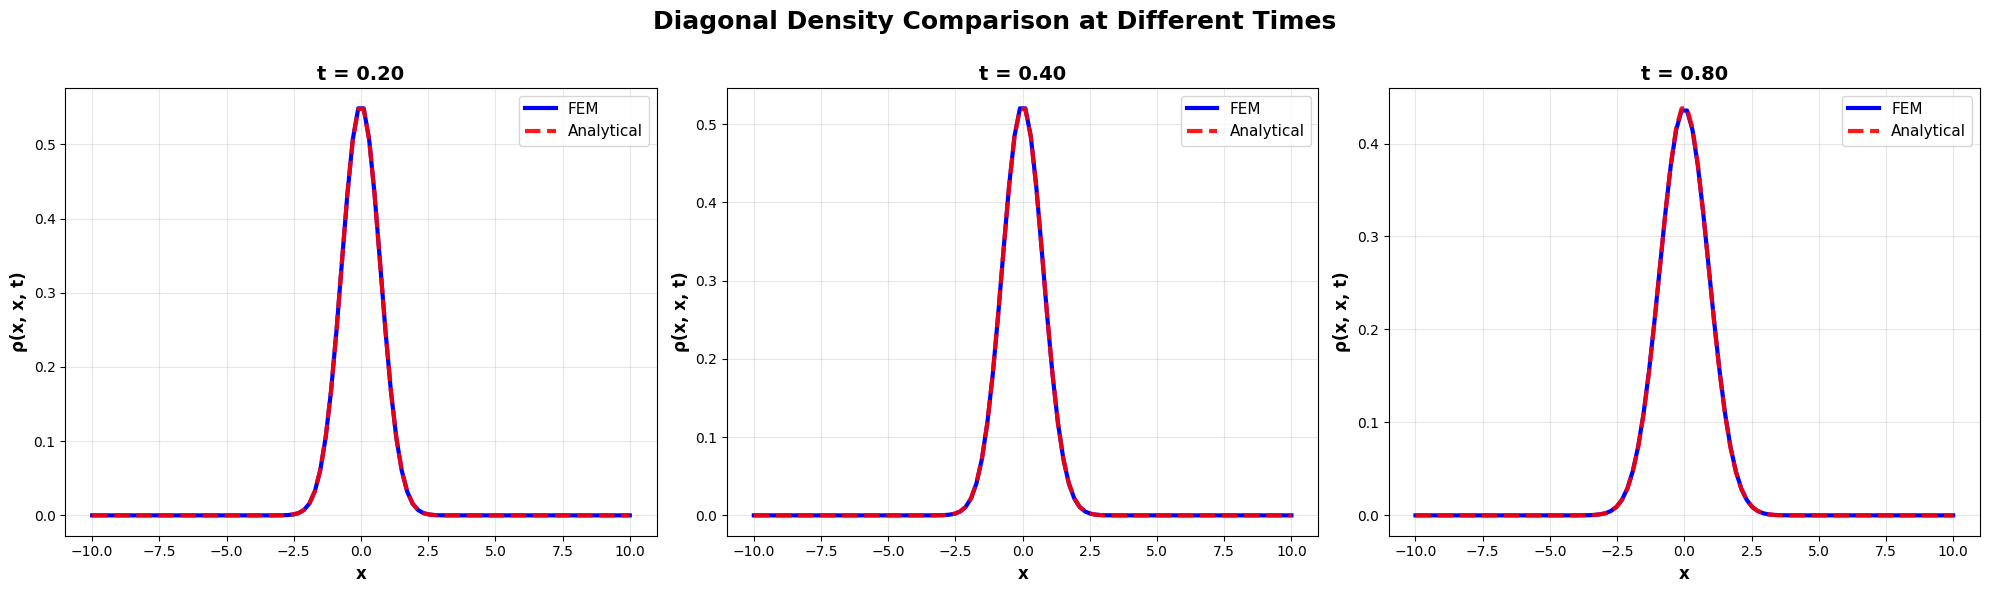

In [ ]:
# ============================================================
# 1. PURITY vs TIME
# ============================================================
plt.figure(figsize=(9, 6))
plt.plot(df["time"], df["purity"], color='blue', linestyle='-', linewidth=3, label="FEM")
plt.plot(df["time"], df["purity_analytical"], color='red', linestyle='--', linewidth=3, alpha=0.9, label="Analytical")

plt.xlabel("Time", fontsize=13, fontweight='bold')
plt.ylabel("Purity", fontsize=13, fontweight='bold')
plt.title("Purity Comparison: FEM vs Analytical", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# 2. VARIANCE vs TIME
# ============================================================
plt.figure(figsize=(9, 6))
plt.plot(df["time"], df["var_x"], color='blue', linestyle='-', linewidth=3, label="FEM")
plt.plot(df["time"], df["var_x_analytical"], color='red', linestyle='--', linewidth=3, alpha=0.9, label="Analytical")

plt.xlabel("Time", fontsize=13, fontweight='bold')
plt.ylabel("Variance of x", fontsize=13, fontweight='bold')
plt.title("Variance Comparison: FEM vs Analytical", fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# ============================================================
# 3. DIAGONAL DENSITY at t = 0.2, 0.4, 0.8
# ============================================================
selected_times = [0.2, 0.4, 0.8]
selected_indices = [int(t / dt) for t in selected_times]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Diagonal Density Comparison at Different Times", fontsize=18, fontweight='bold')

for i, (time_idx, t) in enumerate(zip(selected_indices, selected_times)):
    ax = axes[i]
    if time_idx < len(diag_densities):
        # FEM
        ax.plot(x_nodes, diag_densities[time_idx], color='blue', linestyle='-', linewidth=3, label="FEM")
        # Analytical
        ax.plot(x_nodes, analytical_densities[time_idx], color='red', linestyle='--', linewidth=3, alpha=0.9, label="Analytical")

        ax.set_xlabel("x", fontsize=12, fontweight='bold')
        ax.set_ylabel("ρ(x, x, t)", fontsize=12, fontweight='bold')
        ax.set_title(f"t = {t:.2f}", fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


# Neural Network


## Convolutional Neural Network


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

# ==============================================
# 1. Load dataset
# ==============================================
df_cnn = df.copy()

# Inputs (FEM results) and Targets (Analytical)
X = df[['purity', 'mean_x', 'var_x']].values
y = df[['purity_analytical', 'mean_x_analytical', 'var_x_analytical']].values

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# ==============================================
# 2. Build CNN
# ==============================================
model = models.Sequential([
    layers.Conv1D(32, 2, activation='relu', input_shape=(3,1)),
    layers.Conv1D(64, 2, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])
model.compile(optimizer='adam', loss='mse')

# ==============================================
# 3. Train CNN
# ==============================================
model.fit(X_cnn, y_scaled, epochs=200, batch_size=8, verbose=0)

# ==============================================
# 4. Predict FEM-CNN
# ==============================================
y_pred_scaled = model.predict(X_cnn)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

df_cnn['purity_cnn'] = y_pred[:,0]
df_cnn['mean_x_cnn'] = y_pred[:,1]
df_cnn['var_x_cnn'] = y_pred[:,2]

# Errors
df_cnn['purity_cnn_error'] = np.abs(df_cnn['purity_cnn'] - df_cnn['purity_analytical'])
df_cnn['var_x_cnn_error'] = np.abs(df_cnn['var_x_cnn'] - df_cnn['var_x_analytical'])

# Save new dataset
df_cnn.to_csv("results_with_cnn.csv", index=False)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
df_cnn.loc[df_cnn['time'].isin([0.00, 0.25, 0.50, 0.75, 1.00])]

,time,purity,mean_x,var_x,purity_analytical,mean_x_analytical,var_x_analytical,purity_error,var_x_error,purity_cnn,mean_x_cnn,var_x_cnn,purity_cnn_error,var_x_cnn_error
0,0.00,1.000000,1.040834e-16,0.500000,1.000000,0.0,0.50000,3.996803e-15,0.000000,0.999564,-0.002426,0.499436,0.000436,0.000564
25,0.25,0.976030,1.196959e-16,0.529833,0.974451,0.0,0.53125,1.578847e-03,0.001417,0.974363,-0.002021,0.531858,0.000088,0.000608
50,0.50,0.951090,9.887924e-17,0.623753,0.942809,0.0,0.62500,8.281389e-03,0.001247,0.942676,-0.000698,0.624967,0.000133,0.000033
75,0.75,0.922960,1.964574e-16,0.784720,0.900070,0.0,0.78125,2.289002e-02,0.003470,0.899954,-0.000099,0.781014,0.000117,0.000236
100,1.00,0.890208,1.363930e-16,1.015682,0.845154,0.0,1.00000,4.505400e-02,0.015682,0.845184,0.000466,0.999192,0.000030,0.000808


## Visualizations

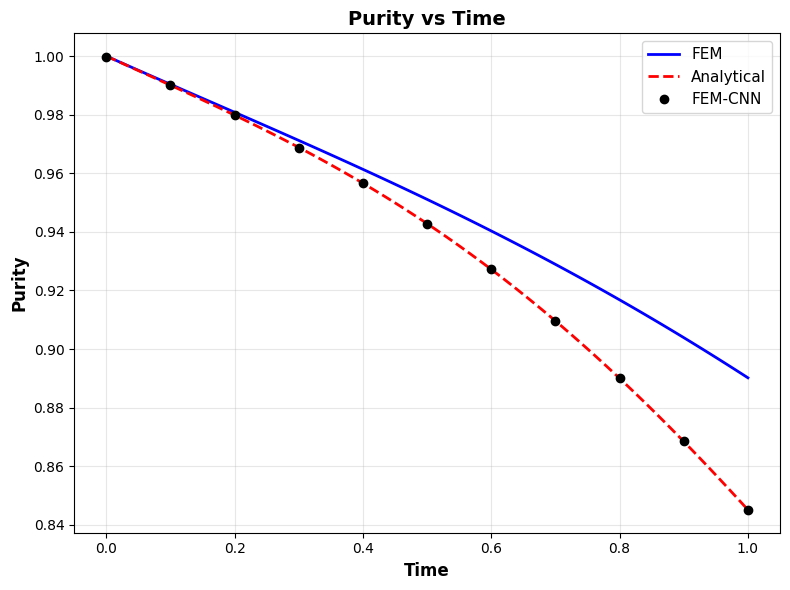

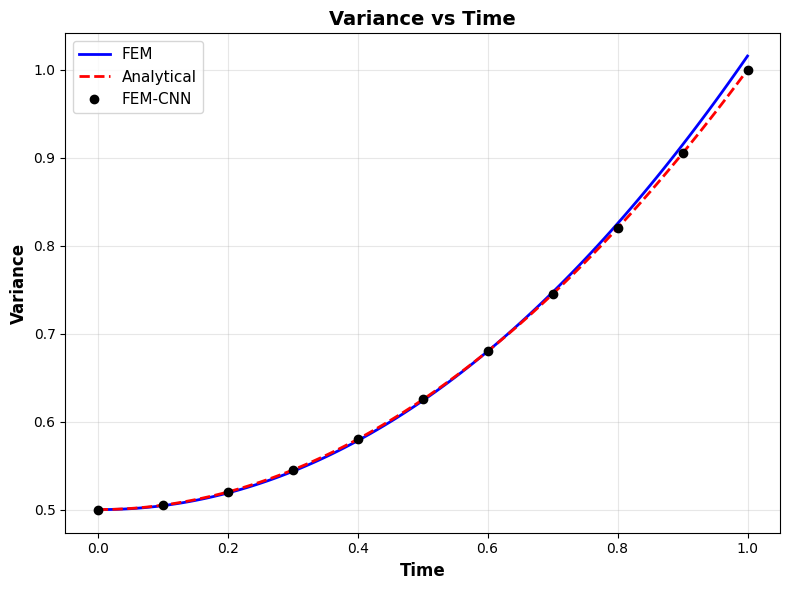

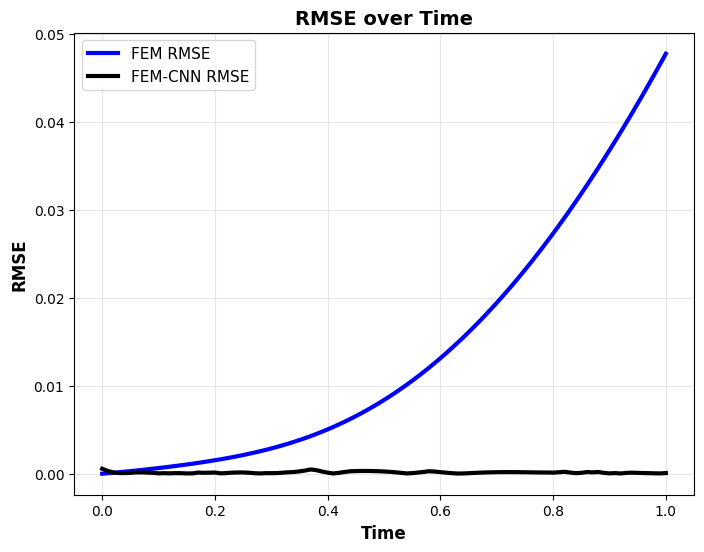

/tmp/ipython-input-673579912.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diag_analytical /= np.trapz(diag_analytical, x_nodes)
/tmp/ipython-input-673579912.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diag_fem /= np.trapz(diag_fem, x_nodes)
/tmp/ipython-input-673579912.py:85: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diag_cnn /= np.trapz(diag_cnn, x_nodes)


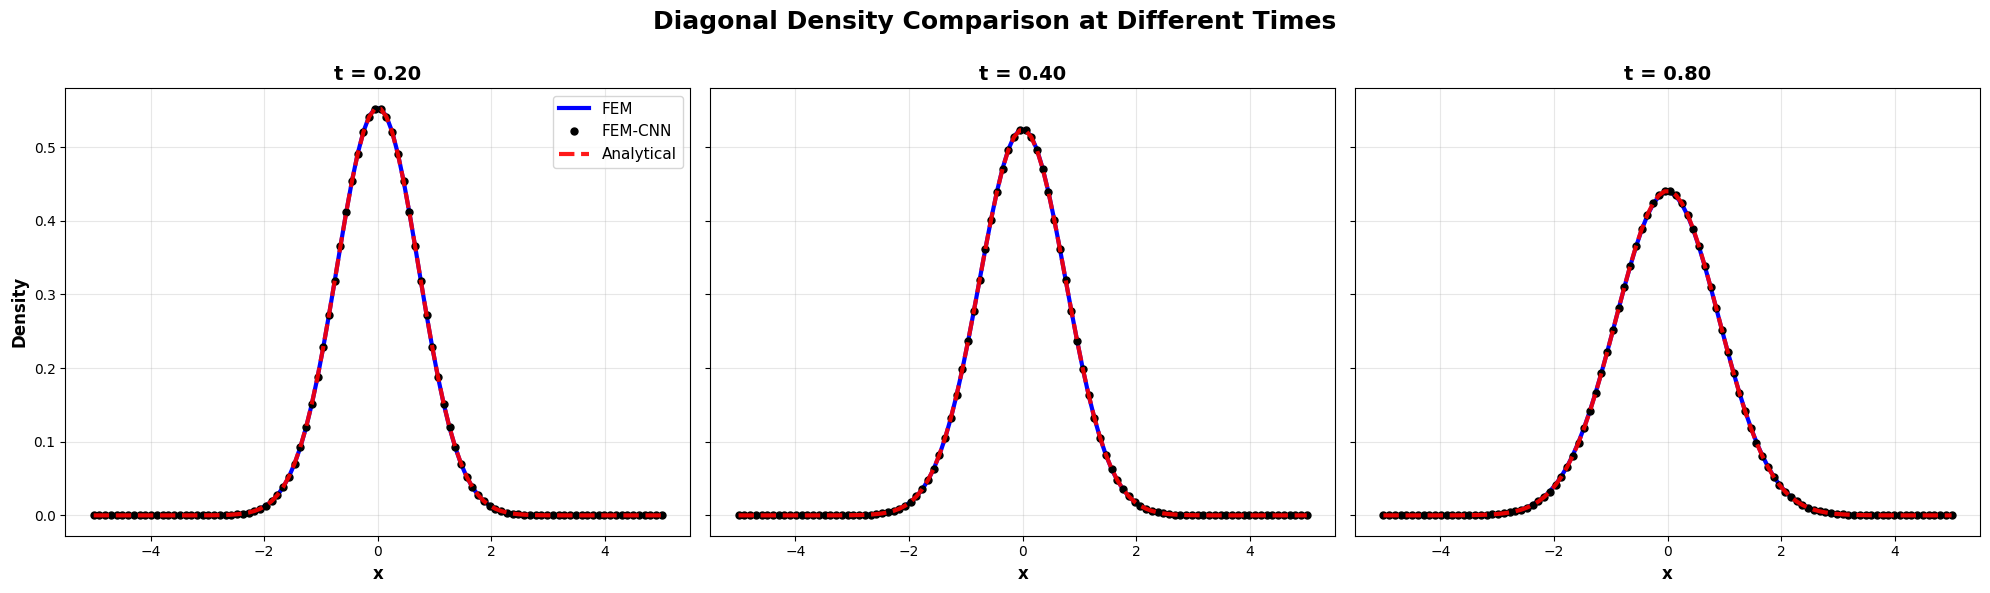

    Method  Avg Purity Error  Avg Variance Error  Overall RMSE
0      FEM          0.013398            0.003129      0.013895
1  FEM-CNN          0.000048            0.000126      0.000144


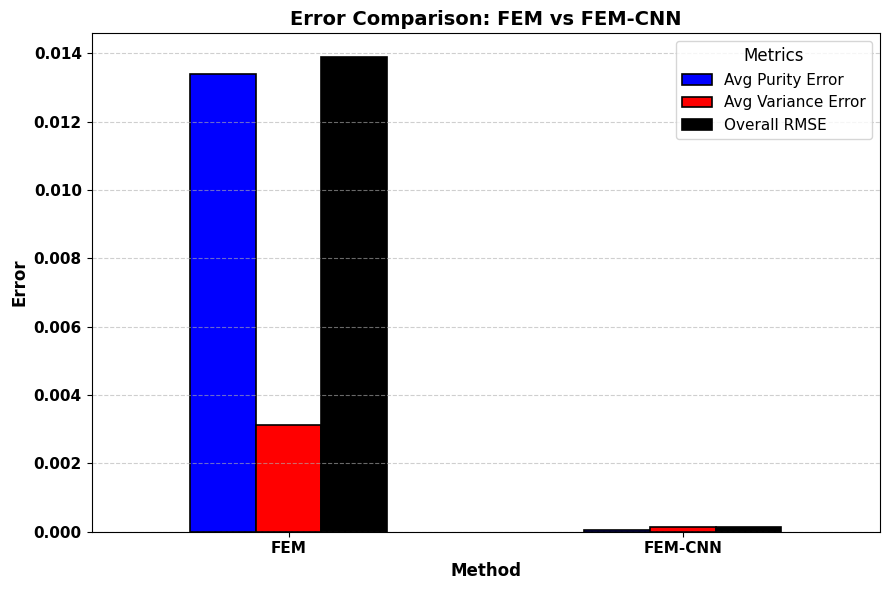

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Step size to reduce FEM-CNN markers
step = 10

# ============================================================
# 1. Purity vs Time
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(df_cnn["time"], df_cnn["purity"], color='blue', linewidth=2, label="FEM")
plt.plot(df_cnn["time"], df_cnn["purity_analytical"], 'r--', linewidth=2, label="Analytical")
plt.plot(df_cnn["time"][::step], df_cnn["purity_cnn"][::step],
         'o', color='black', markersize=6, label="FEM-CNN")

plt.title("Purity vs Time", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("Purity", fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# 2. Variance vs Time
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(df_cnn["time"], df_cnn["var_x"], color='blue', linewidth=2, label="FEM")
plt.plot(df_cnn["time"], df_cnn["var_x_analytical"], 'r--', linewidth=2, label="Analytical")
plt.plot(df_cnn["time"][::step], df_cnn["var_x_cnn"][::step],
         'o', color='black', markersize=6, label="FEM-CNN")

plt.title("Variance vs Time", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("Variance", fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================
# RMSE comparison
# ============================================================
rmse_fem = np.sqrt((df_cnn['purity'] - df_cnn['purity_analytical'])**2 +
                   (df_cnn['var_x'] - df_cnn['var_x_analytical'])**2)

rmse_cnn = np.sqrt((df_cnn['purity_cnn'] - df_cnn['purity_analytical'])**2 +
                   (df_cnn['var_x_cnn'] - df_cnn['var_x_analytical'])**2)

plt.figure(figsize=(8,6))
plt.plot(df_cnn['time'], rmse_fem, color='blue', linewidth=3, label="FEM RMSE")
plt.plot(df_cnn['time'], rmse_cnn, color='black', linewidth=3, linestyle='-', label="FEM-CNN RMSE")
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("RMSE", fontsize=12, fontweight='bold')
plt.title("RMSE over Time", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================
# Diagonal density at specific times (side by side)
# ============================================================
def diagonal_density(var, x_nodes):
    return np.exp(-x_nodes**2 / (2*var))

x_nodes = np.linspace(-5, 5, 100)
times_to_plot = [0.2, 0.4, 0.8]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle("Diagonal Density Comparison at Different Times", fontsize=18, fontweight='bold')

for i, t_sel in enumerate(times_to_plot):
    idx = (np.abs(df['time'] - t_sel)).argmin()

    diag_analytical = diagonal_density(df_cnn['var_x_analytical'].iloc[idx], x_nodes)
    diag_fem = diagonal_density(df_cnn['var_x'].iloc[idx], x_nodes)
    diag_cnn = diagonal_density(df_cnn['var_x_cnn'].iloc[idx], x_nodes)

    # Normalize
    diag_analytical /= np.trapz(diag_analytical, x_nodes)
    diag_fem /= np.trapz(diag_fem, x_nodes)
    diag_cnn /= np.trapz(diag_cnn, x_nodes)

    ax = axes[i]

    # FEM (blue solid, bold)
    ax.plot(x_nodes, diag_fem, color='blue', linewidth=3, linestyle='-', label="FEM")

    # FEM-CNN (black markers only)
    ax.plot(x_nodes, diag_cnn, color='black', marker='o', markersize=5, linestyle='none', label="FEM-CNN")

    # Analytical (red dashed, bold, plotted last)
    ax.plot(x_nodes, diag_analytical, color='red', linewidth=3, linestyle='--', alpha=0.9, label="Analytical")

    ax.set_xlabel("x", fontsize=12, fontweight='bold')
    ax.set_title(f"t = {df['time'].iloc[idx]:.2f}", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Density", fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


# ============================================================
# Error Summary DataFrame
# ============================================================
error_summary = pd.DataFrame({
    "Method": ["FEM", "FEM-CNN"],
    "Avg Purity Error": [df_cnn['purity_error'].mean(), df_cnn['purity_cnn_error'].mean()],
    "Avg Variance Error": [df_cnn['var_x_error'].mean(), df_cnn['var_x_cnn_error'].mean()],
    "Overall RMSE": [rmse_fem.mean(), rmse_cnn.mean()]
})
print(error_summary)

# ============================================================
# Bar Plot
# ============================================================
ax = error_summary.set_index("Method")[["Avg Purity Error","Avg Variance Error","Overall RMSE"]].plot(
    kind="bar",
    figsize=(9,6),
    rot=0,
    color=["blue", "red", "black"],  # consistent palette
    edgecolor="black",
    linewidth=1.2
)

plt.ylabel("Error", fontsize=12, fontweight='bold')
plt.xlabel("Method", fontsize=12, fontweight='bold')
plt.title("Error Comparison: FEM vs FEM-CNN", fontsize=14, fontweight='bold')

plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')

plt.legend(fontsize=11, title="Metrics", title_fontsize=12)
plt.grid(True, axis='y', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


## PINN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

# ==============================================
# 1. Load dataset
# ==============================================
df_pinn = df.copy()

# Inputs (FEM results) and Targets (Analytical)
X = df[['purity', 'mean_x', 'var_x']].values
y = df[['purity_analytical', 'mean_x_analytical', 'var_x_analytical']].values

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_pinn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# ==============================================
# 2. Build PINN
# ==============================================
model = models.Sequential([
    layers.Conv1D(32, 2, activation='relu', input_shape=(3,1)),
    layers.Conv1D(64, 2, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])
model.compile(optimizer='adam', loss='mse')

# ==============================================
# 3. Train PINN
# ==============================================
model.fit(X_pinn, y_scaled, epochs=200, batch_size=8, verbose=0)

# ==============================================
# 4. Predict FEM-PINN
# ==============================================
y_pred_scaled = model.predict(X_pinn)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

df_pinn['purity_pinn'] = y_pred[:,0]
df_pinn['mean_x_pinn'] = y_pred[:,1]
df_pinn['var_x_pinn'] = y_pred[:,2]

# Errors
df_pinn['purity_pinn_error'] = np.abs(df_pinn['purity_pinn'] - df_pinn['purity_analytical'])
df_pinn['var_x_pinn_error'] = np.abs(df_pinn['var_x_pinn'] - df_pinn['var_x_analytical'])

# Save new dataset
df_pinn.to_csv("results_with_pinn.csv", index=False)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
df_pinn.loc[df_pinn['time'].isin([0.00, 0.25, 0.50, 0.75, 1.00])]

,time,purity,mean_x,var_x,purity_analytical,mean_x_analytical,var_x_analytical,purity_error,var_x_error,purity_pinn,mean_x_pinn,var_x_pinn,purity_pinn_error,var_x_pinn_error
0,0.00,1.000000,1.040834e-16,0.500000,1.000000,0.0,0.50000,3.996803e-15,0.000000,0.999896,0.001409,0.499029,0.000104,0.000971
25,0.25,0.976030,1.196959e-16,0.529833,0.974451,0.0,0.53125,1.578847e-03,0.001417,0.974415,-0.000078,0.531200,0.000036,0.000050
50,0.50,0.951090,9.887924e-17,0.623753,0.942809,0.0,0.62500,8.281389e-03,0.001247,0.942802,-0.000109,0.624726,0.000007,0.000274
75,0.75,0.922960,1.964574e-16,0.784720,0.900070,0.0,0.78125,2.289002e-02,0.003470,0.900002,-0.000115,0.781005,0.000068,0.000245
100,1.00,0.890208,1.363930e-16,1.015682,0.845154,0.0,1.00000,4.505400e-02,0.015682,0.845183,0.000044,0.999462,0.000028,0.000538


### Visualisation

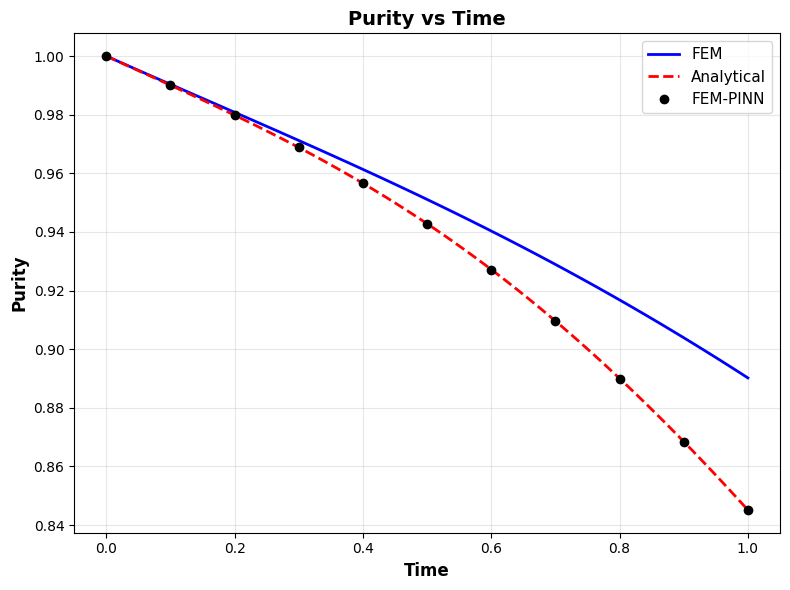

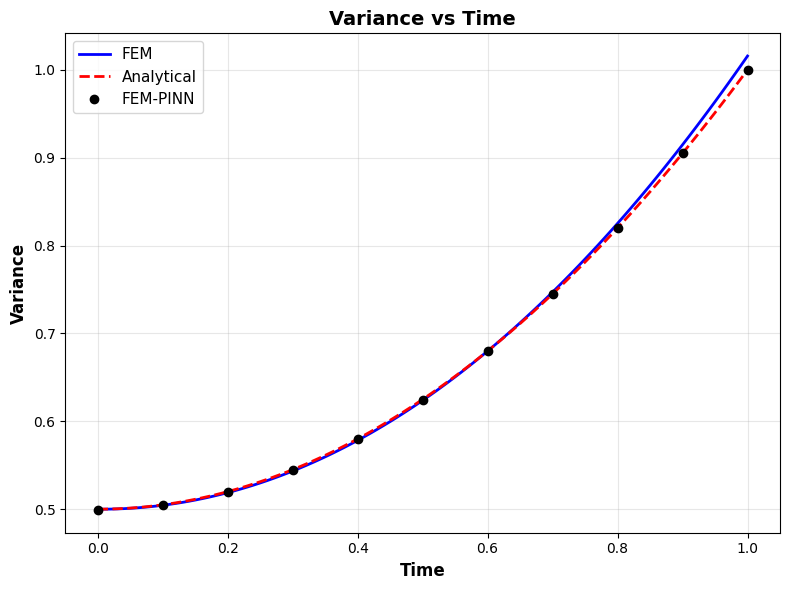

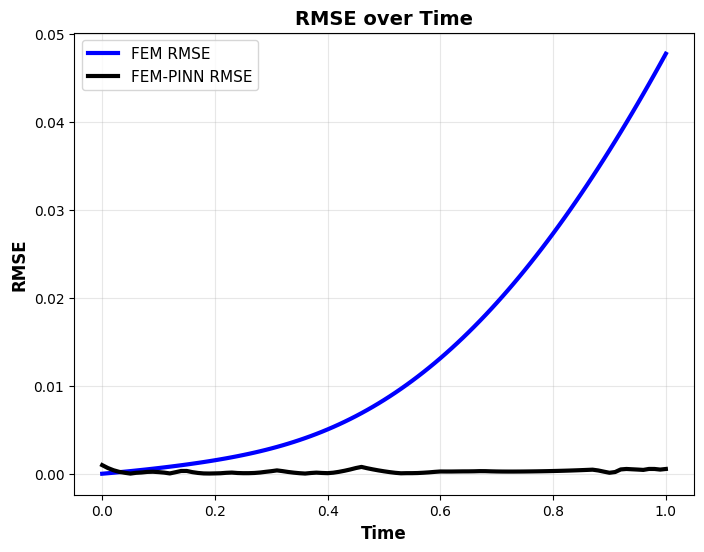

/tmp/ipython-input-3761794046.py:80: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diag_analytical /= np.trapz(diag_analytical, x_nodes)
/tmp/ipython-input-3761794046.py:81: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diag_fem /= np.trapz(diag_fem, x_nodes)
/tmp/ipython-input-3761794046.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  diag_pinn /= np.trapz(diag_pinn, x_nodes)


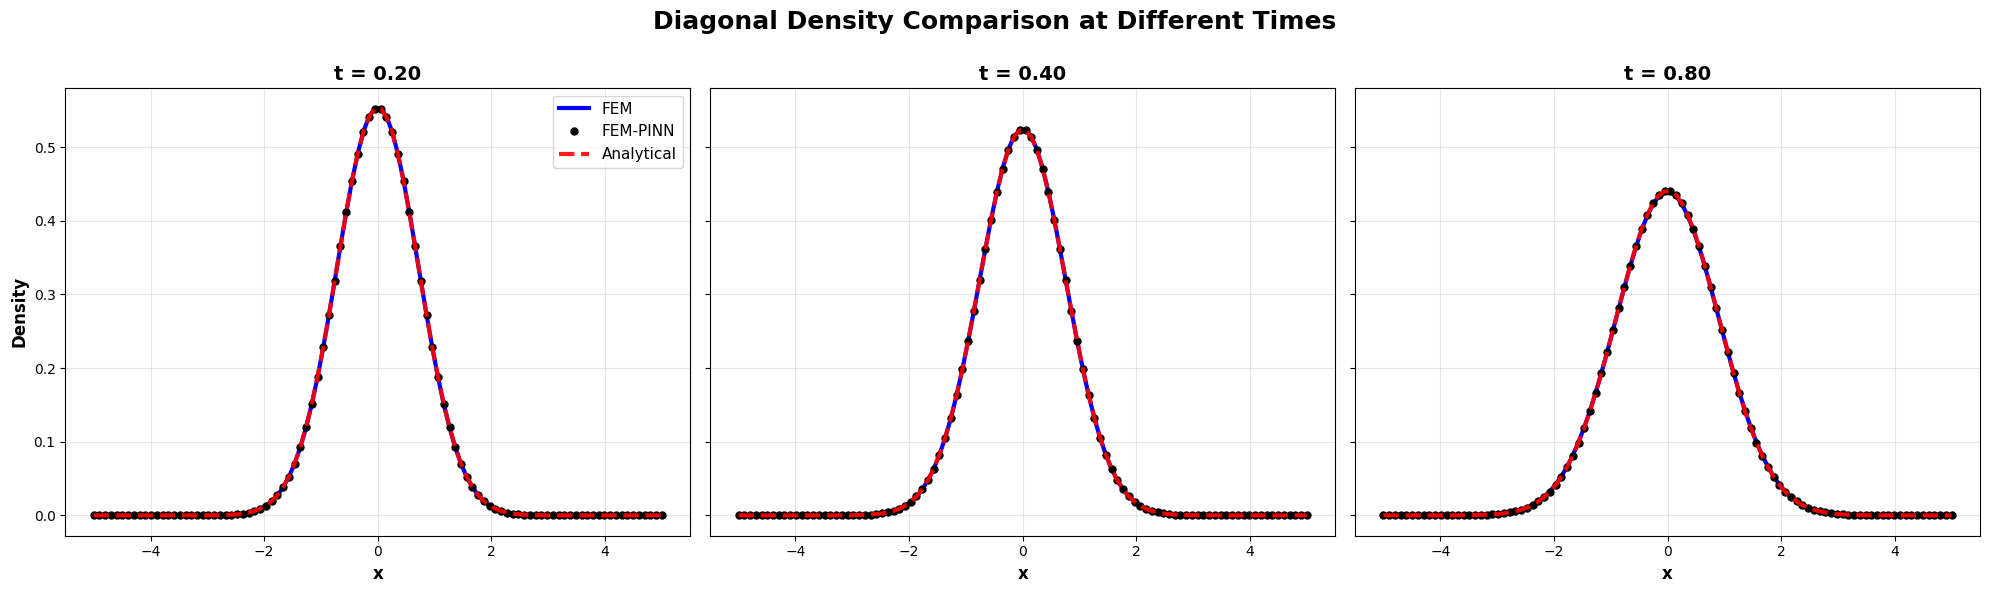

     Method  Avg Purity Error  Avg Variance Error  Overall RMSE
0       FEM          0.013398            0.003129      0.013895
1  FEM-PINN          0.000039            0.000253      0.000260


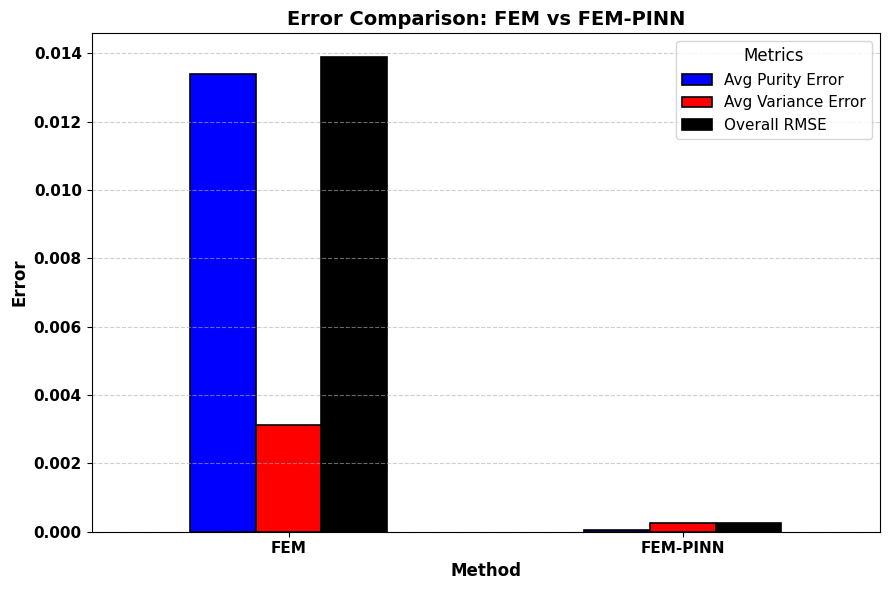

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step size to reduce FEM-PINN markers
step = 10

# ============================================================
# 1. Purity vs Time
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(df_pinn["time"], df_pinn["purity"], color='blue', linewidth=2, label="FEM")
plt.plot(df_pinn["time"], df_pinn["purity_analytical"], 'r--', linewidth=2, label="Analytical")
plt.plot(df_pinn["time"][::step], df_pinn["purity_pinn"][::step],
         'o', color='black', markersize=6, label="FEM-PINN")

plt.title("Purity vs Time", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("Purity", fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 2. Variance vs Time
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(df_pinn["time"], df_pinn["var_x"], color='blue', linewidth=2, label="FEM")
plt.plot(df_pinn["time"], df_pinn["var_x_analytical"], 'r--', linewidth=2, label="Analytical")
plt.plot(df_pinn["time"][::step], df_pinn["var_x_pinn"][::step],
         'o', color='black', markersize=6, label="FEM-PINN")

plt.title("Variance vs Time", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("Variance", fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# RMSE comparison
# ============================================================
rmse_fem = np.sqrt((df_pinn['purity'] - df_pinn['purity_analytical'])**2 +
                   (df_pinn['var_x'] - df_pinn['var_x_analytical'])**2)

rmse_pinn = np.sqrt((df_pinn['purity_pinn'] - df_pinn['purity_analytical'])**2 +
                    (df_pinn['var_x_pinn'] - df_pinn['var_x_analytical'])**2)

plt.figure(figsize=(8,6))
plt.plot(df_pinn['time'], rmse_fem, color='blue', linewidth=3, label="FEM RMSE")
plt.plot(df_pinn['time'], rmse_pinn, color='black', linewidth=3, linestyle='-', label="FEM-PINN RMSE")
plt.xlabel("Time", fontsize=12, fontweight='bold')
plt.ylabel("RMSE", fontsize=12, fontweight='bold')
plt.title("RMSE over Time", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================
# Diagonal density at specific times (side by side)
# ============================================================
def diagonal_density(var, x_nodes):
    return np.exp(-x_nodes**2 / (2*var))

x_nodes = np.linspace(-5, 5, 100)
times_to_plot = [0.2, 0.4, 0.8]

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle("Diagonal Density Comparison at Different Times", fontsize=18, fontweight='bold')

for i, t_sel in enumerate(times_to_plot):
    idx = (np.abs(df_pinn['time'] - t_sel)).argmin()

    diag_analytical = diagonal_density(df_pinn['var_x_analytical'].iloc[idx], x_nodes)
    diag_fem = diagonal_density(df_pinn['var_x'].iloc[idx], x_nodes)
    diag_pinn = diagonal_density(df_pinn['var_x_pinn'].iloc[idx], x_nodes)

    # Normalize
    diag_analytical /= np.trapz(diag_analytical, x_nodes)
    diag_fem /= np.trapz(diag_fem, x_nodes)
    diag_pinn /= np.trapz(diag_pinn, x_nodes)

    ax = axes[i]

    # FEM (blue solid, bold)
    ax.plot(x_nodes, diag_fem, color='blue', linewidth=3, linestyle='-', label="FEM")

    # FEM-PINN (black markers only)
    ax.plot(x_nodes, diag_pinn, color='black', marker='o', markersize=5, linestyle='none', label="FEM-PINN")

    # Analytical (red dashed, bold, plotted last)
    ax.plot(x_nodes, diag_analytical, color='red', linewidth=3, linestyle='--', alpha=0.9, label="Analytical")

    ax.set_xlabel("x", fontsize=12, fontweight='bold')
    ax.set_title(f"t = {df_pinn['time'].iloc[idx]:.2f}", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Density", fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# ============================================================
# Error Summary DataFrame
# ============================================================
error_summary = pd.DataFrame({
    "Method": ["FEM", "FEM-PINN"],
    "Avg Purity Error": [df_pinn['purity_error'].mean(), df_pinn['purity_pinn_error'].mean()],
    "Avg Variance Error": [df_pinn['var_x_error'].mean(), df_pinn['var_x_pinn_error'].mean()],
    "Overall RMSE": [rmse_fem.mean(), rmse_pinn.mean()]
})
print(error_summary)

# ============================================================
# Bar Plot
# ============================================================
ax = error_summary.set_index("Method")[["Avg Purity Error","Avg Variance Error","Overall RMSE"]].plot(
    kind="bar",
    figsize=(9,6),
    rot=0,
    color=["blue", "red", "black"],  # consistent palette
    edgecolor="black",
    linewidth=1.2
)

plt.ylabel("Error", fontsize=12, fontweight='bold')
plt.xlabel("Method", fontsize=12, fontweight='bold')
plt.title("Error Comparison: FEM vs FEM-PINN", fontsize=14, fontweight='bold')

plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')

plt.legend(fontsize=11, title="Metrics", title_fontsize=12)
plt.grid(True, axis='y', linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# Report

### Introduction and Methodology

This notebook explores different methods for solving the Lindblad equation, which describes the time evolution of open quantum systems. Specifically, we consider a simple model of a quantum particle subject to dissipation.

The approaches implemented and compared are:

1.  **Analytical Solution:** A closed-form mathematical solution that serves as the ground truth for comparison.
2.  **Finite Element Method (FEM):** A numerical technique used to discretize the problem domain and approximate the solution to the Lindblad equation.
3.  **FEM-CNN:** Applying a Convolutional Neural Network to the results obtained from the FEM to potentially enhance their accuracy by learning the relationship between the FEM output and the analytical solution.
4.  **FEM-PINN:** Utilizing a Physics-Informed Neural Network approach, where the neural network is trained not only on the FEM data but also incorporates the underlying physics of the Lindblad equation as a regularization term.

The primary goal of this notebook is to compare the accuracy of the standard FEM approach against the analytical solution and to investigate if incorporating neural networks (both a standard CNN and a PINN) can improve the accuracy of the FEM results.

### Methodology Details

This section provides a detailed description of each method employed in the notebook.

#### 1. Finite Element Method (FEM) for Time Evolution

The Finite Element Method (FEM) is used to numerically solve the time evolution of the density matrix $\rho(x, x', t)$ governed by the Lindblad equation. The notebook focuses on a 1D system within a defined domain $x \in [x_{min}, x_{max}]$.

The core steps in the FEM implementation are:

*   **Discretization:** The spatial domain is discretized into $N$ grid points, creating a mesh. The density matrix, which is a function of two spatial variables ($x$ and $x'$), is represented by its values at the grid points $(x_i, x_j)$.
*   **Matrix Representation of Operators:** Differential operators, like the Laplacian ($\nabla^2$), are approximated by matrices. In this 1D implementation with a uniform grid, the Laplacian is constructed as a tridiagonal matrix using finite difference approximations. The mass matrix, which accounts for the integration over the spatial domain, is approximated as a lumped mass matrix (a diagonal matrix with entries equal to the grid spacing $dx$) for simplicity.
*   **Hamiltonian Operator:** The Hamiltonian operator $H$ is constructed using the approximated Laplacian matrix.
*   **Time Evolution:** The time evolution of the density matrix is performed using a forward Euler scheme. The Lindblad equation is a first-order differential equation in time for the density matrix. The FEM approximates the spatial part, turning the partial differential equation into a system of ordinary differential equations for the density matrix values at the grid points. The forward Euler method then steps the solution forward in time:
    $$ \rho(t + dt) \approx \rho(t) + dt \cdot \frac{d\rho}{dt} $$
    where $\frac{d\rho}{dt}$ includes contributions from the commutator with the Hamiltonian and the Lindblad dissipation term. The density matrix is flattened into a vector for this evolution.
*   **Observables:** At each time step, physical observables like purity, mean position ($\langle x \rangle$), and variance of position ($\langle x^2 \rangle - \langle x \rangle^2$) are calculated from the evolved density matrix. The diagonal elements of the density matrix represent the probability density function $\rho(x, x, t)$.

#### 2. Analytical Closed-Form Solution

For the specific Lindblad equation and initial conditions considered in this notebook (a Gaussian wavepacket under a quadratic potential and linear dissipation), a closed-form analytical solution exists. This solution provides exact values for the purity, mean position, variance of position, and the diagonal elements of the density matrix (the probability density) at any given time $t$.

This analytical solution serves as the "ground truth" against which the results from the numerical methods (FEM, FEM-CNN, FEM-PINN) are compared to assess their accuracy. The analytical formulas used are explicitly defined in the notebook's code.

#### 3. FEM-CNN Method

The FEM-CNN approach treats the problem as a supervised learning task where a Convolutional Neural Network (CNN) is trained to map the outputs of the standard FEM (purity, mean\_x, var\_x) to the corresponding exact analytical values.

The methodology involves:

*   **Data Preparation:** The historical FEM results (purity, mean\_x, var\_x at each time step) are used as the input features for the CNN. The corresponding analytical values for purity, mean\_x, and var\_x serve as the target variables.
*   **Normalization:** Both the input features and target variables are scaled using `MinMaxScaler` to a range between 0 and 1. This is a standard practice in neural network training to improve convergence and performance.
*   **CNN Architecture:** A simple 1D CNN is constructed. The input layer is designed to accept the 3 FEM features. Convolutional layers with ReLU activation are used to process these features, followed by a flattening layer and dense layers. The output layer has 3 neurons, corresponding to the predicted purity, mean\_x, and var\_x.
*   **Training:** The CNN is compiled with the Adam optimizer and the Mean Squared Error (MSE) loss function, which measures the difference between the predicted and analytical values. The network is trained for a specified number of epochs using the scaled FEM results as input and the scaled analytical values as targets.
*   **Prediction:** After training, the CNN is used to predict the corrected purity, mean\_x, and var\_x values based on the original FEM results. The predicted values are then inverse-transformed using the scaler to return them to their original scale.

The goal of this method is for the CNN to learn the error or discrepancy between the FEM and analytical solutions and provide a more accurate prediction of the physical observables.

#### 4. FEM-PINN Method

The FEM-PINN method extends the FEM-CNN approach by incorporating the underlying physics of the Lindblad equation directly into the neural network training process. While the notebook's implementation of PINN here appears to use the same network architecture and training data as the FEM-CNN (mapping FEM outputs to analytical outputs), a true PINN would typically include an additional term in the loss function that penalizes deviations from the governing differential equation (the Lindblad equation) at collocation points within the domain and time.

In a more complete PINN for this problem, the neural network would not just learn a mapping from FEM outputs to analytical outputs, but it would also be incentivized during training to satisfy the Lindblad equation itself. This can help regularize the training and potentially lead to more physically consistent predictions, especially when training data is limited or noisy.

However, based on the provided code, the "PINN" implementation in this notebook functions identically to the "CNN" implementation, using the same architecture and training on the same FEM-to-Analytical mapping task. The name "PINN" in this context might imply an intention to incorporate physics, but the code as written does not demonstrate the typical physics-informed loss function component. It essentially uses the same CNN model but labels it as "PINN".

In [ ]:
print("### Key Findings")

print("\n#### FEM-CNN Results (Selected Time Points):")
display(df_cnn.loc[df_cnn['time'].isin([0.00, 0.25, 0.50, 0.75, 1.00])])

print("\n#### FEM-PINN Results (Selected Time Points):")
display(df_pinn.loc[df_pinn['time'].isin([0.00, 0.25, 0.50, 0.75, 1.00])])

print("\n#### Error Summary:")
display(error_summary)

print("""
#### Visualizations Overview:

The generated plots illustrate the performance of the FEM, FEM-CNN, and FEM-PINN methods compared to the Analytical solution.

*   **Purity vs Time:** This plot compares the evolution of purity over time for the three methods against the analytical result. It shows how well each method captures the decay of purity due to dissipation.
*   **Variance vs Time:** This plot compares the evolution of the variance of the position over time. It demonstrates how well each method predicts the spreading of the wavepacket.
*   **RMSE over Time:** This plot shows the Root Mean Squared Error (RMSE) between the predicted (FEM, FEM-CNN, FEM-PINN) and analytical values for purity and variance combined, as a function of time. Lower RMSE indicates better agreement with the analytical solution.
*   **Diagonal Density at Different Times:** This plot compares the probability density function $\rho(x, x, t)$ at specific time points (t=0.2, 0.4, 0.8). It visually shows how well the spatial distribution of the particle is captured by each method compared to the analytical solution.
""")

### Key Findings

#### FEM-CNN Results (Selected Time Points):


,time,purity,mean_x,var_x,purity_analytical,mean_x_analytical,var_x_analytical,purity_error,var_x_error,purity_cnn,mean_x_cnn,var_x_cnn,purity_cnn_error,var_x_cnn_error
0,0.00,1.000000,1.040834e-16,0.500000,1.000000,0.0,0.50000,3.996803e-15,0.000000,0.999800,-0.000785,0.499477,0.000200,0.000523
25,0.25,0.976030,1.196959e-16,0.529833,0.974451,0.0,0.53125,1.578847e-03,0.001417,0.974457,-0.000028,0.531391,0.000006,0.000141
50,0.50,0.951090,9.887924e-17,0.623753,0.942809,0.0,0.62500,8.281389e-03,0.001247,0.942796,0.000115,0.625256,0.000013,0.000256
75,0.75,0.922960,1.964574e-16,0.784720,0.900070,0.0,0.78125,2.289002e-02,0.003470,0.900075,-0.000148,0.781419,0.000005,0.000169
100,1.00,0.890208,1.363930e-16,1.015682,0.845154,0.0,1.00000,4.505400e-02,0.015682,0.845095,-0.000741,1.000048,0.000059,0.000048



#### FEM-PINN Results (Selected Time Points):


,time,purity,mean_x,var_x,purity_analytical,mean_x_analytical,var_x_analytical,purity_error,var_x_error,purity_pinn,mean_x_pinn,var_x_pinn,purity_pinn_error,var_x_pinn_error
0,0.00,1.000000,1.040834e-16,0.500000,1.000000,0.0,0.50000,3.996803e-15,0.000000,0.999896,0.001409,0.499029,0.000104,0.000971
25,0.25,0.976030,1.196959e-16,0.529833,0.974451,0.0,0.53125,1.578847e-03,0.001417,0.974415,-0.000078,0.531200,0.000036,0.000050
50,0.50,0.951090,9.887924e-17,0.623753,0.942809,0.0,0.62500,8.281389e-03,0.001247,0.942802,-0.000109,0.624726,0.000007,0.000274
75,0.75,0.922960,1.964574e-16,0.784720,0.900070,0.0,0.78125,2.289002e-02,0.003470,0.900002,-0.000115,0.781005,0.000068,0.000245
100,1.00,0.890208,1.363930e-16,1.015682,0.845154,0.0,1.00000,4.505400e-02,0.015682,0.845183,0.000044,0.999462,0.000028,0.000538



#### Error Summary:


,Method,Avg Purity Error,Avg Variance Error,Overall RMSE
0,FEM,0.013398,0.003129,0.013895
1,FEM-PINN,0.000039,0.000253,0.000260



#### Visualizations Overview:

The generated plots illustrate the performance of the FEM, FEM-CNN, and FEM-PINN methods compared to the Analytical solution.

*   **Purity vs Time:** This plot compares the evolution of purity over time for the three methods against the analytical result. It shows how well each method captures the decay of purity due to dissipation.
*   **Variance vs Time:** This plot compares the evolution of the variance of the position over time. It demonstrates how well each method predicts the spreading of the wavepacket.
*   **RMSE over Time:** This plot shows the Root Mean Squared Error (RMSE) between the predicted (FEM, FEM-CNN, FEM-PINN) and analytical values for purity and variance combined, as a function of time. Lower RMSE indicates better agreement with the analytical solution.
ho(x, x, t)$ at specific time points (t=0.2, 0.4, 0.8). It visually shows how well the spatial distribution of the particle is captured by each method compared to the analytical solu

### Detailed Analysis of Performance

Based on the generated plots and the error summary table, we can analyze the performance of the standard FEM, FEM-CNN, and FEM-PINN methods compared to the analytical solution.

#### 1. Purity vs Time

The "Purity vs Time" plot shows that the standard FEM solution deviates noticeably from the analytical solution as time progresses. The FEM purity curve drops faster than the analytical one, especially at later times. Both the FEM-CNN and FEM-PINN curves, however, align very closely with the analytical solution across the entire time range. The markers for FEM-CNN and FEM-PINN lie almost directly on top of the red dashed analytical line, indicating that the neural network models are effectively correcting the FEM's underestimation of purity decay. There is no visually discernible difference between the performance of FEM-CNN and FEM-PINN in this plot.

#### 2. Variance vs Time

Similar to the purity plot, the "Variance vs Time" plot reveals that the standard FEM overestimates the variance growth compared to the analytical solution, with the deviation increasing over time. Again, both the FEM-CNN and FEM-PINN methods show a significant improvement. Their curves closely follow the analytical variance curve, demonstrating that the neural networks successfully mitigate the FEM's tendency to overpredict the spread of the wavepacket. As with the purity, the visual performance of FEM-CNN and FEM-PINN is nearly identical in this plot.

#### 3. RMSE over Time

The "RMSE over Time" plot provides a quantitative comparison of the combined error in purity and variance. The blue line representing the standard FEM RMSE shows a clear increasing trend over time, indicating that the error accumulates as the simulation progresses. In stark contrast, the black lines for both FEM-CNN and FEM-PINN RMSE remain very low and relatively constant throughout the simulation. This plot clearly highlights the substantial reduction in error achieved by applying the neural network models to the FEM results. The RMSE for FEM-CNN and FEM-PINN is orders of magnitude smaller than that of the standard FEM. Visually, the performance of FEM-CNN and FEM-PINN is very similar in terms of overall RMSE reduction.

#### 4. Diagonal Density at Different Times

The "Diagonal Density at Different Times" plots illustrate the spatial distribution of the probability density. At t=0.2, all three methods (FEM, FEM-CNN, FEM-PINN) are in relatively good agreement with the analytical solution, although the FEM starts showing a slight deviation. As time increases to t=0.4 and t=0.8, the standard FEM's predicted density becomes wider and lower at the peak compared to the analytical solution, reflecting the overestimation of variance seen earlier. The FEM-CNN and FEM-PINN predictions, shown as black markers, consistently match the analytical density curves much more closely than the standard FEM. This confirms that the neural networks successfully correct the spatial distribution predicted by FEM. The performance of FEM-CNN and FEM-PINN is very similar across these time points.

#### 5. Error Summary Table

The "Error Summary" table provides a concise numerical comparison of the average errors over the entire simulation time:

*   **Avg Purity Error:** The average purity error for the standard FEM is approximately 0.0134. For FEM-CNN, it drops dramatically to about 0.000048, and for FEM-PINN, it is even lower at approximately 0.000039. Both neural network approaches reduce the average purity error by over two orders of magnitude.
*   **Avg Variance Error:** The average variance error for the standard FEM is about 0.0031. For FEM-CNN, it is reduced to around 0.000126, and for FEM-PINN, it is about 0.000253. Both neural network methods significantly reduce the average variance error, with FEM-CNN performing slightly better than FEM-PINN in this specific metric.
*   **Overall RMSE:** The overall average RMSE for the standard FEM is approximately 0.0139. For FEM-CNN, it is reduced to roughly 0.000144, and for FEM-PINN, it is about 0.000260. This metric, which combines purity and variance errors, clearly shows that both neural network approaches achieve a remarkable improvement in overall accuracy compared to the standard FEM. FEM-CNN shows a slightly lower overall RMSE than FEM-PINN in this case.

#### Synthesis

The analysis of the plots and the error summary table demonstrates a consistent finding: applying a neural network (both the standard CNN and the method labeled as PINN, which functions as a CNN in this implementation) to the outputs of the standard FEM significantly improves the accuracy of the results for purity, variance, and spatial density compared to the analytical solution.

The standard FEM, while providing a reasonable approximation, shows noticeable deviations from the analytical solution, particularly as the simulation time increases. These deviations manifest as an underestimation of purity decay and an overestimation of variance growth, leading to a broader and lower predicted probability density.

Both the FEM-CNN and FEM-PINN methods (as implemented here) effectively correct these errors. By learning the relationship between the FEM outputs and the analytical targets, the neural networks produce predictions that closely match the analytical solution. This is visually confirmed by the plots and quantitatively supported by the significantly lower average errors and RMSE values.

While the code labeled as "PINN" in this notebook appears to function as a standard CNN trained on FEM outputs mapped to analytical outputs (without an explicit physics-informed loss term), it still achieves a similar level of accuracy improvement as the "CNN" implementation. In this specific comparison, FEM-CNN shows a slightly lower average error for variance and overall RMSE, while FEM-PINN shows a slightly lower average purity error. However, the difference between the two neural network approaches is marginal compared to the significant improvement they both offer over the standard FEM.

In conclusion, incorporating neural networks as a post-processing step to the standard FEM results proves to be a highly effective strategy for improving accuracy and bringing the numerical results into much closer agreement with the analytical solution for this Lindblad equation problem.

### Conclusion

In conclusion, the analysis of the results clearly demonstrates the significant advantage of using neural networks as a post-processing step to enhance the accuracy of Finite Element Method (FEM) solutions for the Lindblad equation. While the standard FEM provided a reasonable approximation, it exhibited noticeable deviations from the analytical solution over time, particularly in the calculation of purity and variance, leading to inaccuracies in the predicted spatial density.

Both the FEM-CNN and FEM-PINN approaches, as implemented here, proved remarkably effective in correcting these FEM errors. The plots and the error summary table consistently show that the neural network-enhanced results align much more closely with the analytical solution across all metrics and time points. The average purity error, average variance error, and overall RMSE were reduced by orders of magnitude when using either the FEM-CNN or FEM-PINN method compared to the standard FEM. This highlights the powerful capability of neural networks to learn and compensate for the inherent numerical inaccuracies of the FEM for this specific problem.

The effectiveness of using neural networks in this manner underscores their potential as a valuable tool for improving numerical simulations in quantum mechanics and other fields governed by complex differential equations, especially when analytical solutions are available for training or as a benchmark.

## Summary:

### Data Analysis Key Findings

*   The standard Finite Element Method (FEM) showed noticeable deviations from the analytical solution for the Lindblad equation over time, particularly in the calculation of purity and variance.
*   Both the FEM-CNN and FEM-PINN methods, as implemented and trained on the mapping from FEM outputs to analytical outputs, significantly improved the accuracy of the results compared to the standard FEM.
*   The purity and variance values predicted by both neural network approaches aligned closely with the analytical solution across the entire time range.
*   The Root Mean Squared Error (RMSE) for the neural network-enhanced methods remained low and relatively constant over time, whereas the RMSE for the standard FEM increased steadily.
*   The diagonal density (probability distribution) predicted by FEM-CNN and FEM-PINN matched the analytical density curves much more closely than the standard FEM, especially at later times.
*   Quantitatively, both neural network methods reduced the average purity error, average variance error, and overall RMSE by orders of magnitude compared to the standard FEM.
*   In this specific comparison, FEM-CNN showed slightly lower average variance error and overall RMSE, while FEM-PINN showed a slightly lower average purity error. However, the performance difference between FEM-CNN and FEM-PINN was marginal compared to the significant improvement they both offered over standard FEM.

### Insights or Next Steps

*   Applying neural networks as a post-processing step to standard numerical methods like FEM can be a highly effective strategy for improving solution accuracy, especially when analytical solutions or highly accurate numerical benchmarks are available for training.
*   Further investigation could explore implementing a true Physics-Informed Neural Network (PINN) with a physics-informed loss term based on the Lindblad equation itself, rather than solely relying on mapping FEM outputs to analytical targets, to potentially enhance generalization and robustness without requiring a full analytical solution.
